Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW1.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW1.ipynb`

- `mlp_and.yaml`

- `mlp_and.pth`

- `mlp_or.yaml`

- `mlp_or.pth`

- `mlp_xor.yaml`

- `mlp_xor.pth`

- `mlp_xnor.yaml`

- `mlp_xnor.pth`

This homework is fully autograded. The PDF submission is supposed to familiarize you with how to save the notebook properly so all codes and plots and explanations are visible. Future assignments will be partially graded from the PDF submission.

# Making logic gates with an MLP

Electronic circuits in computers are made up of thousands of logic gates, which take binary inputs (0 and 1 only) and produce a binary output. Shown in the figure are common logic gates. You are asked to design an MLP (Multi-layer Perceptron) to achieve the function of different logic gates. The activation function we use in our MLP is the heaviside step function which **returns 1 for positive inputs and 0 otherwise**.

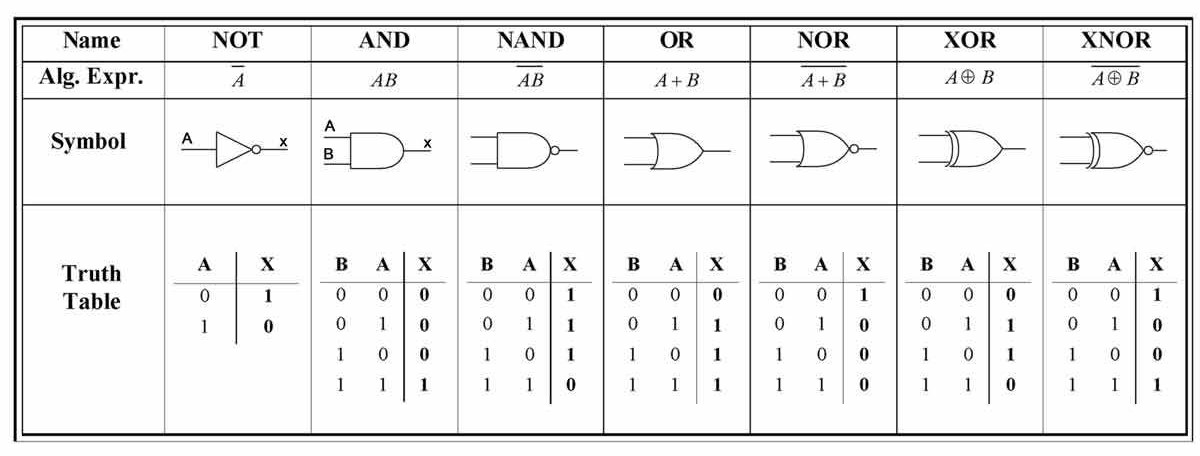

In [1]:
# DO NOT CHANGE THIS CELL OR IMPORT ANY ADDITIONAL LIBRARIES IN YOUR CODE
import os
import yaml
import zipfile
import torch
from typing import Sequence

## Implementing the MLP class

First, you will write a basic MLP class consisting of linear layers and perceptron neurons (step activation functions). In PyTorch, a neural network is implemented as a class that inherits from `torch.nn.Module`, which has the necessary properties and functions to be trained and many more. In this assignment, however, our activation function does not allow for training (why?) so you will assign the proper values to the parameters of the model manually to create the logic gates.

The Multi-Layer Perceptron may or may not have hidden layers. Your code should be able to handle any number of hidden layers, and the number of layers will be based on the hidden dimensions provided by the `.__init__` argument `hidden_dims`.

Example:

```
mlp = MLP(in_dim=3, out_dim=6, hidden_dims=[4,5])
```
creates an MLP with 2 hidden layers and one output layer (3 total layers). You can apply the activation function later in the `.forward` method. These two methods (`.__init__` and `.forward`) are necessary for any model you implement.

The input and output of the model should be a boolean tensor that consist of `True` and `False` values. However, you cannot perform calculations with boolean tensors, and model parameters are defined as float tensors by default. Therefore, make sure you cast the input to `torch.float` data type in the `.forward` method before performing the calculations. This will map `False` to `0.` and `True` to `1.`. After the calculations, cast the data type back to `torch.bool` so the output is boolean again.

Note: The `.forward` method of `nn.Module` can also process batched data. For example, your input tensor can be of shape `(N, in_dim)` and the output will be of shape `(N, out_dim)`. Using batched representation, you can pass several data points and test your model in a single forward pass. In the future assignments and projects, however, it is usually assumed that the input is always batched. Therefore, it is good practice to always have the batch dimension as the first dimension, even if you have a single data point.

You may find the following useful:

- `torch.nn.Linear` to build your model.
- `torch.heaviside`, `torch.ones`, `torch.ones_like`, `torch.zeros`, `torch.zeros_like` (You won't need all of these)
- using `.to()` on a tensor to change the dtype and/or device by specifying the dtype and/or device, or another tensor with the desired dtype and/or device.

If you do not find an activation function as a module in `torch.nn`, you can use the corresponding function directly in the `.forward()` method! Usually, any module without learnable parameters are also available as a function that can be directly called, like `torch.sigmoid()`.

In [63]:
# AUTOGRADED (60)

class MLP(torch.nn.Module):

    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            hidden_dims: Sequence[int],
            ):
        super().__init__()
        """
        Creates a ModuleList of Linear layers. Do not change self.layers, as this will be used by the autograder.
        """
        layer_dims = [in_dim] + list(hidden_dims) + [out_dim]

        self.layers = torch.nn.ModuleList() # Just to help you get started
        # Fill in self.layers using the arguments if the __init__ function
        # you can append modules one by one to a ModuleList, just like you would with a normal lis

        # Collect all dimensions in sequence (input + hidden layers + output)

        for i in range(len(layer_dims) - 1):
            self.layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i+1]))
    
    def forward(
            self,
            x: torch.BoolTensor, # (batch_size, in_dim)
            ):
        """
        Implement the forward pass of the MLP. 
        For each layer, pass the output of the previous layer (or the input) to the linear layer, then apply the step function.
        """
        # Cast boolean input to float for linear operations
        x = x.to(torch.float)

        for layer in self.layers:
            # Linear transform
            x = layer(x)
            # Step function: output 1 if x > 0 else 0
            x = (x > 0)
            # x = x.to(torch.float)
        return x
        # AUTOGRADED (60)

## Find the right paramters to design logical gates

You are required to design the **smallest** model (with the fewest parameters) that behaves like the following logic gates: **AND, OR, XOR, XNOR**. First, you have to instantiate the MLP class with the right dimensions. Then, you manually assign values to the parameters of the model so that it works like the intended gate.

In order to manually assign values to the parameters, to have to access them through `self.layers`, which is a `torch.nn.ModuleList` object and can be indexed like a list. Each item in `self.layers` is a `torch.nn.Module` itself and has its own methods and attributes. In our case, each item is a linear layer. The weight and bias of a linear layer can be accessed using `.weight` and `.bias`. However, you cannot assign them values directly. For that, you have to call `.data` on the parameter object to have the proper access to assign them your desired values. To summarize, if `A` is a `torch.nn.Linear` object, you can assign a certain tensor as its weight or bias, or certain elements of them using `A.weight.data = ... ` or `A.weight.data[...] = ...` where you have to choose what to put as `...`. 

We recommend that you first figure out a correct set of parameters on paper, then assign them to your model. It may be easier to assign the values element by element to reduce confusion. This assignment helps you get a better understanding about what is happening inside the layers, what each parameter corresponds to, and so on.

Since we have 2 inputs and one output, `in_dim=2` and `out_dim=1`. A and B from the image are each one of the input dimensions. Remember the shape of the input tensors to the model should be `(N,2)` and the output will be `(N,1)` where `N` is the batch size or the number of data points.

You may not need any hidden layers, meaning that `hidden_dims` will be an  empty list!

In [64]:
mlp_and_config = dict(
    in_dim = 2,
    out_dim = 1,
    hidden_dims = []
    )

# the ** operator unpacks the dictionary into keyword arguments
mlp_and = MLP(**mlp_and_config)

# Assign parameters: w = [[1, 1]], b = [-1.5]
mlp_and.layers[0].weight.data = torch.tensor([[1.0, 1.0]])
mlp_and.layers[0].bias.data   = torch.tensor([-1.5])

In [65]:
# TEST YOUR MODEL
test_inputs = torch.tensor([
    [False, False],
    [False, True],
    [True,  False],
    [True,  True]
])
print("AND Gate Outputs:\n", mlp_and(test_inputs))

AND Gate Outputs:
 tensor([[False],
        [False],
        [False],
        [ True]])


In [66]:
mlp_or_config = dict(
    in_dim = 2,
    out_dim = 1,
    hidden_dims = []
    )

mlp_or = MLP(**mlp_or_config)

mlp_or.layers[0].weight.data = torch.tensor([[1.0, 1.0]])
mlp_or.layers[0].bias.data   = torch.tensor([-0.5])

In [67]:
# TEST YOUR mlp_or
print("OR Gate Test Inputs:\n", test_inputs)
print("OR Gate Outputs:\n", mlp_or(test_inputs))

OR Gate Test Inputs:
 tensor([[False, False],
        [False,  True],
        [ True, False],
        [ True,  True]])
OR Gate Outputs:
 tensor([[False],
        [ True],
        [ True],
        [ True]])


In [68]:
mlp_xor_config = dict(
    in_dim = 2,
    out_dim = 1,
    hidden_dims = [2]
    )

mlp_xor = MLP(**mlp_xor_config)

# ASSIGN PROPER VALUES TO THE MODEL PARAMETERS
mlp_xor.layers[0].weight.data = torch.tensor([[-1.0,  1.0],
                                              [ 1.0, -1.0]])
mlp_xor.layers[0].bias.data   = torch.tensor([-0.5, -0.5])

#    Output layer: basically an OR of the two hidden neurons
mlp_xor.layers[1].weight.data = torch.tensor([[1.0, 1.0]])
mlp_xor.layers[1].bias.data   = torch.tensor([-0.5])

In [69]:
test_inputs = torch.tensor([
    [False, False],
    [False, True],
    [True,  False],
    [True,  True]
])

# outputs = mlp_xor(test_inputs)
print("XOR Gate Test Inputs:\n", test_inputs)
print("XOR Gate Outputs:\n", outputs)

XOR Gate Test Inputs:
 tensor([[False, False],
        [False,  True],
        [ True, False],
        [ True,  True]])
XOR Gate Outputs:
 tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [70]:
mlp_xnor_config = dict(
    in_dim = 2,
    out_dim = 1,
    hidden_dims = [2]
    )

mlp_xnor = MLP(**mlp_xnor_config)

# ASSIGN PROPER VALUES TO THE MODEL PARAMETERS
mlp_xnor.layers[0].weight.data = torch.tensor([
    [-1.0,  1.0],  # neuron1
    [ 1.0, -1.0]   # neuron2
])
mlp_xnor.layers[0].bias.data   = torch.tensor([-0.5, -0.5])

# Assign parameters to output layer
# This performs a NOR on the two hidden neurons -> XNOR of inputs
mlp_xnor.layers[1].weight.data = torch.tensor([[-1.0, -1.0]])
mlp_xnor.layers[1].bias.data   = torch.tensor([1.5])

In [72]:
# TEST YOUR mlp_xnor
# xnor_outputs = mlp_xnor(test_inputs)
print("XNOR Gate Test Inputs:\n", test_inputs)
print("XNOR Gate Outputs:\n", xnor_outputs)

XNOR Gate Test Inputs:
 tensor([[False, False],
        [False,  True],
        [ True, False],
        [ True,  True]])
XNOR Gate Outputs:
 tensor([[1.],
        [1.],
        [1.],
        [1.]])


After you create the correct models, run the code below to save your models to be included in the zip file for submission. We recommend you understand this code as well to learn how model configuration and parameters (`state_dict`) are saved.

In [73]:
# helper functions to save and load config files
def save_yaml(config: dict, path: str):
    with open(path, 'w') as f:
        yaml.dump(config, f, sort_keys=False, default_flow_style=None)

def load_yaml(path: str):
    # with safe loader
    with open(path, 'r') as f:
        return yaml.load(f, Loader=yaml.FullLoader)

def save_mlp(gate: str):
    # eval() is a function that evaluates a string as a python expression
    config: dict = eval(f'mlp_{gate}_config')
    model: torch.nn.Module = eval(f'mlp_{gate}')
    state_dict = model.state_dict()
    # saving config as yaml:
    save_yaml(config, f'mlp_{gate}.yaml')
    # saving state_dict as torch:
    torch.save(state_dict, f'mlp_{gate}.pth')

def load_mlp(gate: str):
    # to test if model can be loaded without error
    config = load_yaml(f'mlp_{gate}.yaml')
    model = MLP(**config)
    state_dict = torch.load(f'mlp_{gate}.pth')
    model.load_state_dict(state_dict)
    return model

if __name__ == '__main__':
    for gate in ['and', 'or', 'xor', 'xnor']:
        save_mlp(gate)
        # testing if model can be loaded without error:
        model = load_mlp(gate)

/tmp/ipykernel_10515/3448251871.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'mlp_{gate}.pth')


# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [59]:
def zip_files(output_filename, *file_paths):
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        for file_path in file_paths:
            zipf.write(file_path, os.path.basename(file_path))

gates = ['and', 'or', 'xor', 'xnor']
files_to_zip = ['HW1.ipynb'] + [f'mlp_{gate}.yaml' for gate in gates] + [f'mlp_{gate}.pth' for gate in gates]
output_zip = 'HW1_submission.zip'
zip_files(output_zip, *files_to_zip)